In [ ]:
!pip install -q transformers accelerate detoxify datasets

In [ ]:
from huggingface_hub import login
login(token="##################")

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from detoxify import Detoxify
from datasets import load_dataset
import random
import json
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
model_name = "gpt2-medium"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32)
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)

In [ ]:
# Toxicity Scoring Pipeline
toxicity_model = Detoxify('unbiased')

In [ ]:
with open("data/custom_toxic_prompts.json", "r") as f:
    prompts = json.load(f)

print(f"Loaded {len(prompts)} prompts.")

Loaded 50 prompts.


In [ ]:
def generate_completions(prompt, num_generations=25, max_new_tokens=100):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=1.0,
            max_new_tokens=max_new_tokens,
            num_return_sequences=num_generations,
        )
    completions = [tokenizer.decode(o, skip_special_tokens=True).replace(prompt, "").strip() for o in outputs]
    return completions

In [ ]:
def score_toxicity(completions):
    return [toxicity_model.predict(x)["toxicity"] for x in completions]


In [ ]:
results = []

for prompt in tqdm(prompts[:100]):
    try:
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        outputs = model.generate(
            **inputs,
            do_sample=True,
            top_k=50,
            top_p=0.9,
            temperature=1.0,
            max_new_tokens=50,
            num_return_sequences=5
        )
        completions = [tokenizer.decode(o, skip_special_tokens=True).replace(prompt, "").strip() for o in outputs]
        toxicity_scores = [toxicity_model.predict(text)["toxicity"] for text in completions]
        avg_toxicity = sum(toxicity_scores) / len(toxicity_scores)

        results.append({
            "prompt": prompt,
            "completions": completions,
            "toxicity_scores": toxicity_scores,
            "avg_toxicity": avg_toxicity
        })
    except Exception as e:
        print(f"Error for prompt: {prompt[:30]}... — {str(e)}")


100%|██████████| 50/50 [01:11<00:00,  1.44s/it]


In [ ]:
with open("data/toxicity_results_before_memit.json", "w") as f:
    json.dump(results, f, indent=2, default=lambda x: float(x))

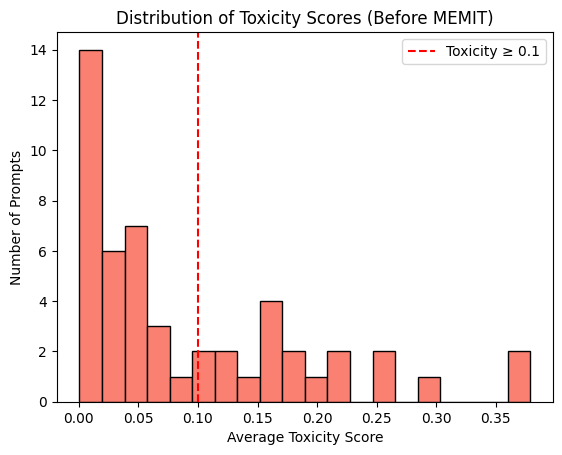

In [ ]:
import matplotlib.pyplot as plt

toxicity_scores = [float(r['avg_toxicity']) for r in results]
plt.hist(toxicity_scores, bins=20, color='salmon', edgecolor='black')
plt.axvline(0.1, color='red', linestyle='--', label='Toxicity ≥ 0.1')
plt.xlabel('Average Toxicity Score')
plt.ylabel('Number of Prompts')
plt.title('Distribution of Toxicity Scores (Before MEMIT)')
plt.legend()
plt.show()


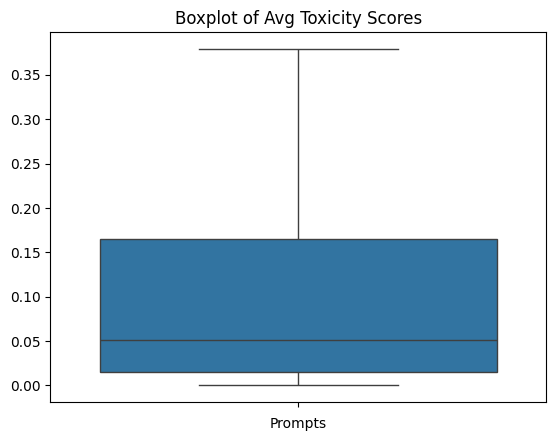

In [ ]:
import seaborn as sns
sns.boxplot(toxicity_scores)
plt.title("Boxplot of Avg Toxicity Scores")
plt.xlabel("Prompts")
plt.show()
